# **Phase 2: Customer Segmentation Using a Gaussian Mixture Model**
This notebook details the second phase of the analysis: segmenting customers into distinct personas based on their purchasing behavior. The goal is to move beyond simple RFM (Recency, Frequency, Monetary) scores and use a probabilistic clustering model to uncover more nuanced customer groups.

**Methodology:**
1.  **Feature Engineering:** A customer-centric dataframe is created by aggregating transactional data. We will engineer features based on RFM principles, such as `num_orders`, `days_since_last`, and `total_purchases`, as well as a custom `customer_activity_score`.
2.  **Data Transformation:** Statistical tests will be performed to check for normality and equal variance. A `QuantileTransformer` will be used to transform the skewed feature distributions into a Gaussian-like distribution suitable for the GMM algorithm.
3.  **Hyperparameter Tuning:** The `Optuna` library will be used to systematically find the optimal hyperparameters for the Gaussian Mixture Model, minimizing the Bayesian Information Criterion (BIC) to identify the best model configuration.
4.  **Modeling & Evaluation:** A GMM is trained using the optimized parameters and compared against a baseline K-Means model, using both quantitative metrics (Silhouette Score, Davies-Bouldin) and qualitative visual analysis to determine the superior model.

In [ ]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats import descriptivestats
from IPython.display import display, HTML, Image
import plotly.io as pio
import plotly.express as px
import json
from urllib.request import urlopen
from collections import Counter
import string
import re
import scipy
import scipy.cluster
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pio.templates.default = "plotly_dark"

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;"'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;"{df.to_html(index=True)}</div'
    html_str += '</div'
    
    display(HTML(html_str))

### **1. Data Loading and Preparation**
We begin by loading the dataset from the previous phase, which now includes the product category classifications. We will then create a customer-centric view of the data.

In [2]:
#Read the parquet file that we generated on the category clustering notebook
df = pd.read_parquet('notebook referenced files\\Sales with Stock Categories.parquet')
display_side_by_side(df.head())
display_side_by_side(df.tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850,3.00,Misc - Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,6.00,Bases and Holders
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850,3.00,Misc - Other
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680,10.00,Misc - Designed
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680,10.00,Misc - Designed
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85,2011-12-09,12,12680,10.00,Misc - Designed


### **2. Feature Engineering with RFM Principles**
To segment customers, we must transform the transactional data into a customer-level summary. The following code iterates through each unique `CustomerID` to calculate several key metrics inspired by RFM analysis:
-   **Recency:** `days_since_last` (Days since the customer's last purchase)
-   **Frequency:** `num_orders` (Total number of unique orders)
-   **Monetary:** `total_purchases` (Total monetary value of all purchases)
-   **Additional Metrics:** We also include `total_unique_stock` to measure purchase variety.

These aggregated statistics are stored in a dictionary and then converted into a new dataframe, `customer_stats_df`, for analysis.

In [4]:
#First let's get the subset of data that we need
customers_df = df[['InvoiceNo', 'StockCode', 'Quantity', 'TotalPrice', 'InvoiceDay', 'CustomerID_str', 'Category']]
customers_with_id = customers_df[~(customers_df['CustomerID_str'] =='nan')]
customers_with_id

#Initialize some date variables to be used later
df_last_date = df.iat[-1, 9]
df_first_date = df.iat[0, 9]
df_date_delta = df_last_date - df_first_date

In [5]:
#Group the dataframe that is to be analyzed with the information that we plan on clustering
customers_with_id_filtered = customers_with_id[['Quantity', 'TotalPrice','CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']].groupby(['CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']).sum()
customers_with_id_filtered
customer_with_id_reset = customers_with_id_filtered.reset_index(level=['InvoiceNo', 'InvoiceDay', 'StockCode'])
customer_with_id_reset

#Initialize a dictionary that will be used to store calculations on customer transaction statistics
customer_stats_dict = {}
customer_list = list(set(customer_with_id_reset.index))
customer_reindexed = customer_with_id_reset.reset_index()

In [6]:
#Gather data on each customer by iteration, store calculations on totals, averages, ordering tendencies and recency.
for customer in customer_list:
    cust_df = customer_reindexed[customer_reindexed['CustomerID_str'] == customer]
    num_orders = len(np.unique(cust_df['InvoiceNo']))
    num_order_days =  len(np.unique(cust_df['InvoiceDay']))
   
    days_since_last = df_last_date - cust_df.iat[-1, 2]
    days_since_last_num = days_since_last.days
    days_since_first = df_last_date - cust_df.iat[0, 2]
    days_since_first_num = days_since_first.days
        
    total_quantity = np.sum(cust_df['Quantity'])
    total_purchases = np.sum(cust_df['TotalPrice'])

    average_quantity = total_quantity/num_orders
    average_total = total_purchases /num_orders

    unique_orders = cust_df['InvoiceNo'].unique()
    unique_items_purchased = []

    for order in unique_orders:
        transactions_df = cust_df[cust_df['InvoiceNo'] == order]
        unique_items_purchased.append(len(np.unique(transactions_df['StockCode'])))

    total_unique_stock_purchased = len(np.unique(cust_df['StockCode']))
    total_unique_stock_per_order = np.sum(unique_items_purchased)
    average_unique_stock_per_order = total_unique_stock_per_order/num_orders

    customer_stats_dict[customer] = [num_orders, num_order_days, days_since_last_num, average_unique_stock_per_order, average_quantity, average_total, total_unique_stock_purchased, total_quantity,total_purchases]


In [7]:
#Create a dataframe out of the dictionary from the previous cell
customer_stats = pd.DataFrame(customer_stats_dict)
customer_stats_df = customer_stats.T
customer_stats_df.columns = ['num_orders', 'num_order_days', 'days_since_last', 'ave_stock_per_order', 'ave_qty', 'ave_purchased', 'total_unique_stock', 'total_qty', 'total_purchases']
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases
13854,25.00,25.00,8.00,4.40,91.84,324.38,39.00,2296.00,8109.52
16903,1.00,1.00,29.00,50.00,262.00,373.24,50.00,262.00,373.24
17125,1.00,1.00,50.00,34.00,291.00,259.35,34.00,291.00,259.35
13328,1.00,1.00,316.00,17.00,680.00,1308.48,17.00,680.00,1308.48
12910,8.00,6.00,23.00,9.38,211.50,384.38,48.00,1692.00,3075.04
...,...,...,...,...,...,...,...,...,...
14082,1.00,1.00,364.00,28.00,110.00,182.25,28.00,110.00,182.25
16177,1.00,1.00,50.00,15.00,95.00,331.95,15.00,95.00,331.95
12508,2.00,2.00,26.00,32.00,136.00,199.13,57.00,272.00,398.27
13722,3.00,2.00,131.00,28.33,467.00,791.80,75.00,1401.00,2375.41


#### **2.1. Engineering a Custom `customer_activity_score`**
To create a single, powerful metric for customer engagement, we engineer a `customer_activity_score`. This score is calculated as the ratio of a customer's scaled order frequency to their scaled purchase recency.

-   **Logic:** Higher scores are the result of bigger numerators (`num_orders`) and smaller denominators (`days_since_last`), which conceptually describes customers who order frequently and has purchased recently. A low score indicates infrequent, lapsed customers.
-   **Scaling:** `MinMaxScaler` is used to ensure both `num_orders` and `days_since_last` are on the same scale, giving them equal weight in the calculation.

In [8]:
customer_activity = customer_stats_df[['num_orders', 'days_since_last']]
mm_scaler = MinMaxScaler(feature_range=(1,100)).set_output(transform='pandas')
customer_activity_scaled = mm_scaler.fit_transform(customer_activity)
customer_activity_scaled['customer_activity_score'] = customer_activity_scaled['num_orders']/customer_activity_scaled['days_since_last']

#Add this new column to the main df
score_dict = customer_activity_scaled['customer_activity_score'].to_dict()
customer_stats_df['customer_activity_score'] = customer_stats_df.index.map(score_dict)
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
13854,25.00,25.00,8.00,4.40,91.84,324.38,39.00,2296.00,8109.52,4.03
16903,1.00,1.00,29.00,50.00,262.00,373.24,50.00,262.00,373.24,0.11
17125,1.00,1.00,50.00,34.00,291.00,259.35,34.00,291.00,259.35,0.07
13328,1.00,1.00,316.00,17.00,680.00,1308.48,17.00,680.00,1308.48,0.01
12910,8.00,6.00,23.00,9.38,211.50,384.38,48.00,1692.00,3075.04,0.62
...,...,...,...,...,...,...,...,...,...,...
14082,1.00,1.00,364.00,28.00,110.00,182.25,28.00,110.00,182.25,0.01
16177,1.00,1.00,50.00,15.00,95.00,331.95,15.00,95.00,331.95,0.07
12508,2.00,2.00,26.00,32.00,136.00,199.13,57.00,272.00,398.27,0.19
13722,3.00,2.00,131.00,28.33,467.00,791.80,75.00,1401.00,2375.41,0.05


### **3. Exploratory Data Analysis of Customer Features**
Before modeling, we perform EDA to understand the distribution of our newly engineered features. The descriptive statistics and boxplots below reveal that the features are heavily right-skewed and contain numerous extreme outliers. This is typical for customer purchasing data but must be addressed before applying clustering algorithms that assume normal distributions.

In [9]:
from statsmodels.stats import descriptivestats
#Get an overview of the numerical columns we plan on using as features for our clusters
stats_df = descriptivestats.describe(customer_stats_df[['customer_activity_score', 'total_unique_stock', 'total_qty', 'total_purchases']])
display_side_by_side(stats_df[:15].round(2), stats_df[15:].round(2))

,customer_activity_score,total_unique_stock,total_qty,total_purchases
nobs,4334.00,4334.00,4334.00,4334.00
missing,0.00,0.00,0.00,0.00
mean,0.69,61.43,1189.98,2021.47
std_err,0.04,1.30,76.60,135.30
upper_ci,0.77,63.97,1340.11,2286.67
lower_ci,0.61,58.89,1039.84,1756.28
std,2.82,85.31,5042.96,8907.50
iqr,0.41,61.00,831.75,1326.06
iqr_normal,0.30,45.22,616.58,983.01
mad,0.89,50.10,1306.40,2204.75


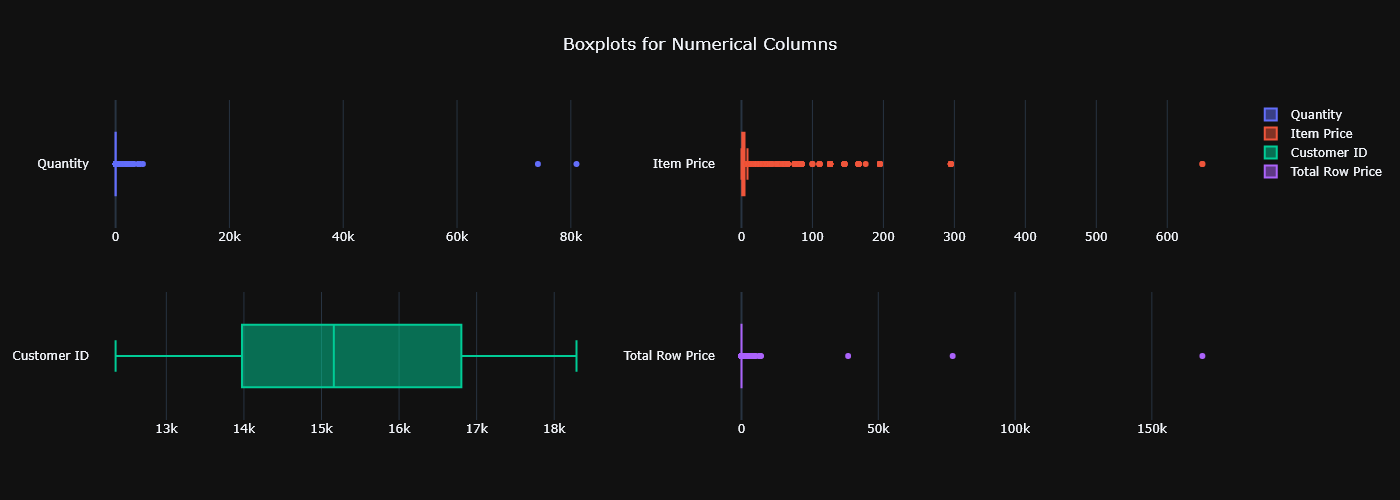

In [ ]:
#Let's create some boxplots to see how our values are distributed
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.2)

hist1 = go.Box(x=customer_stats_df['customer_activity_score'], name='customer_activity_score')
hist2 = go.Box(x=customer_stats_df['total_unique_stock'], name ='total_unique_stock')
hist3 = go.Box(x=customer_stats_df['total_qty'], name='total_qty')
hist4 = go.Box(x=customer_stats_df['total_purchases'], name='total_purchases')

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Boxplots for Numerical Columns', title_x = 0.5, width=1600)


#pio.write_image(fig, 'boxplot_num.png')
Image('boxplot_num.png')

**Figure 1: Distribution of Raw Customer Features**
The boxplots clearly visualize the extreme skew and outliers present in the data, particularly in `total_qty` and `total_purchases`. This confirms the need for data transformation.

---
#### **3.1. Filtering Extreme Outliers**
To ensure the clustering algorithm focuses on the primary population distribution, we will filter out the most extreme outliers. These often represent anomalous accounts (e.g., single massive wholesale orders) that can distort the cluster centers. We apply thresholds based on the 99th percentile and visual inspection of the boxplots.

In [11]:
#Extreme outliers can be seen from the graphs above so we will filter those out
customer_stats_no_outliers = customer_stats_df[(customer_stats_df['customer_activity_score'] < 60) & (customer_stats_df['total_unique_stock'] < 1000) & (customer_stats_df['total_qty'] < 100000) & (customer_stats_df['total_purchases'] < 200000)]
customer_stats_no_outliers.sort_values(by='customer_activity_score', ascending=False)

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
15311,91.00,90.00,0.00,25.90,419.71,667.78,567.00,38194.00,60767.90,44.46
14606,90.00,88.00,1.00,29.52,69.04,133.41,816.00,6214.00,12006.65,34.76
13089,97.00,66.00,2.00,18.68,320.31,606.45,636.00,31070.00,58825.83,30.94
13408,62.00,41.00,1.00,7.71,261.81,453.50,234.00,16232.00,28117.04,24.07
12971,86.00,71.00,3.00,3.55,108.01,130.12,94.00,9289.00,11189.91,23.41
...,...,...,...,...,...,...,...,...,...,...
14237,1.00,1.00,373.00,9.00,38.00,161.00,9.00,38.00,161.00,0.01
17968,1.00,1.00,373.00,74.00,160.00,277.35,74.00,160.00,277.35,0.01
12791,1.00,1.00,373.00,1.00,96.00,177.60,1.00,96.00,177.60,0.01
15350,1.00,1.00,373.00,5.00,51.00,115.65,5.00,51.00,115.65,0.01


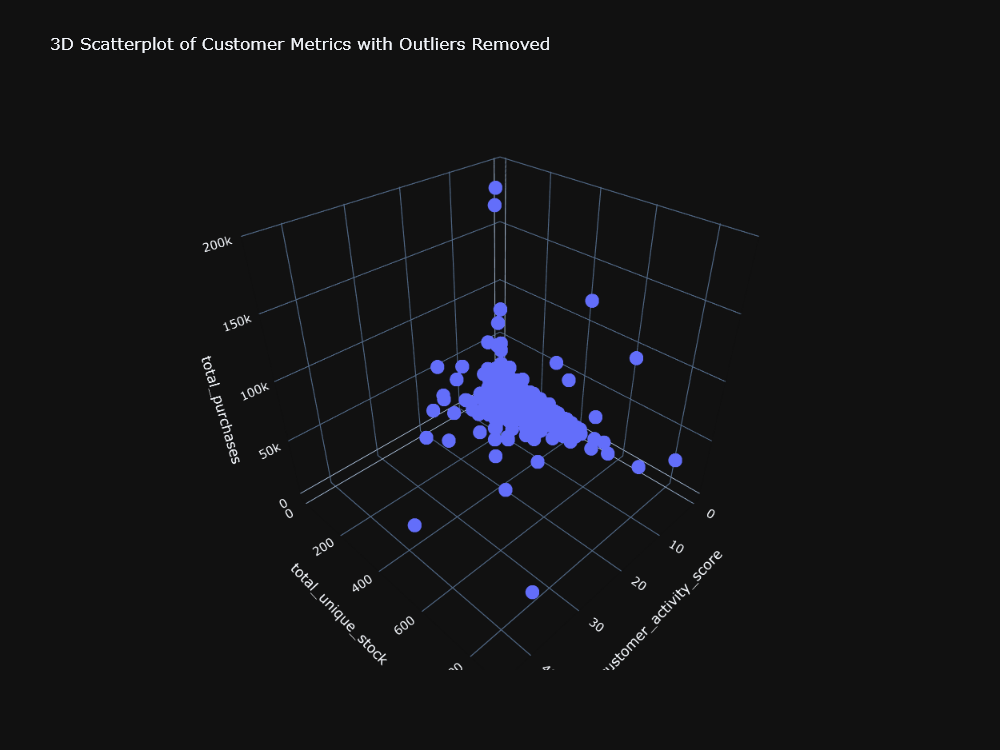

In [ ]:
scatter_no_outlier = px.scatter_3d(data_frame=customer_stats_no_outliers, x='customer_activity_score', y='total_unique_stock', z='total_purchases', title='3D Scatterplot of Customer Metrics with Outliers Removed', height=750, width = 1000)
#pio.write_image(scatter_no_outlier, 'scatter_no_outlier.png')
Image('scatter_no_outlier.png')

**Figure 2: 3D Visualization of Customer Data (Outliers Removed)**
This 3D scatter plot shows the relationships between our key features after outlier removal. While no obvious, distinct clusters are visible to the naked eye, the data is now more concentrated, making it more suitable for a probabilistic algorithm like GMM to find underlying patterns.

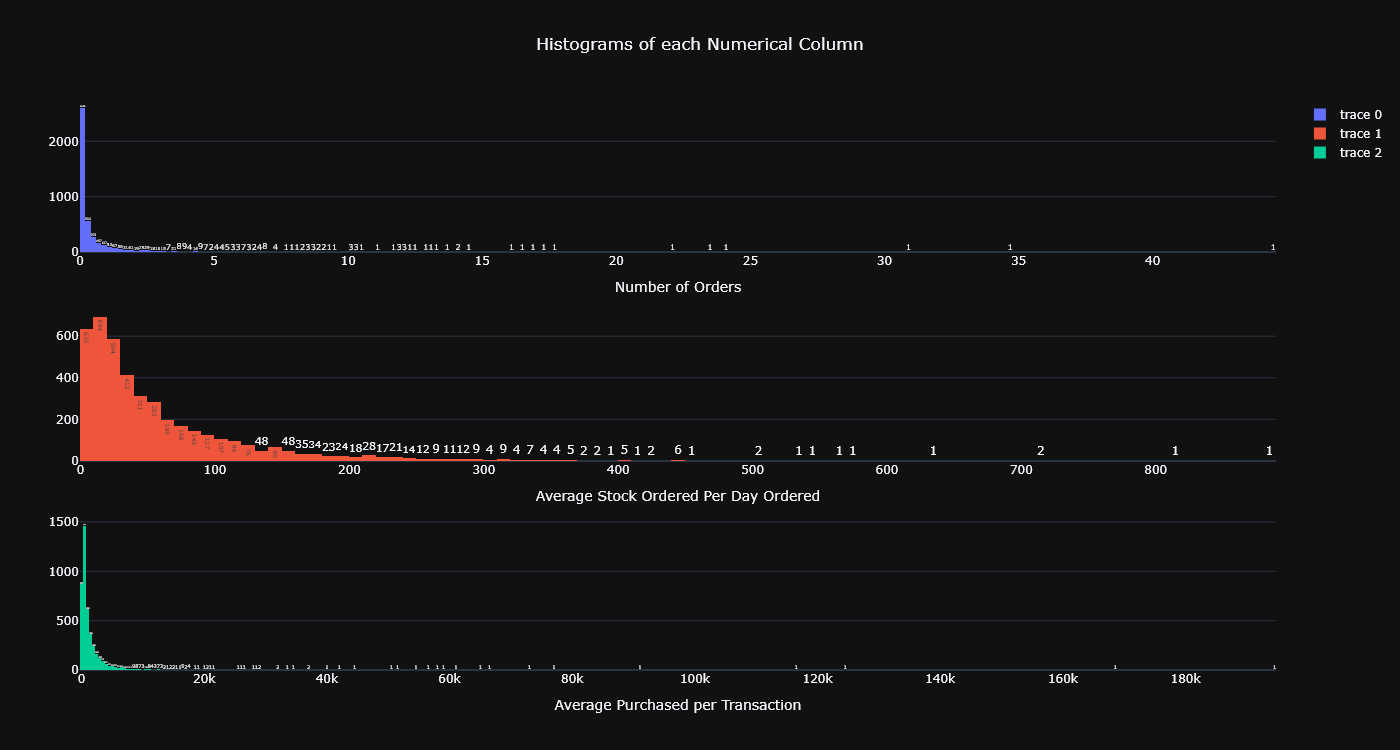

In [ ]:
#Create histograms to show the distribution of each column after removing outliers above
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_no_outliers['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_no_outliers['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_no_outliers['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text='Number of Orders', row=1, col=1)
fig.update_xaxes(title_text='Average Stock Ordered Per Day Ordered', row=2, col=1)
fig.update_xaxes(title_text=f'Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Histograms of each Numerical Column', title_x = 0.5, width =1400, height = 750)
#pio.write_image(fig, 'hist_clust.png')
Image('hist_clust.png')

 ### **4. Statistical Validation and Data Transformation**
To prepare for Gaussian Mixture Modeling, we must address two key assumptions: equal variance and multivariate normality.

-   **Bartlett's Test:** This tests the null hypothesis that all input samples are from populations with equal variances.
-   **Henze-Zirkler Test:** This is a specific test for multivariate normality.

As the results below show, both tests fail (p-value is 0.0), allowing us to reject the null hypotheses. Our data does not have equal variances and is not normally distributed.

In [14]:
import scipy.stats as stats
from pingouin import multivariate_normality

#Let's run some tests
stat, p_value = stats.bartlett(customer_stats_no_outliers['customer_activity_score'], customer_stats_no_outliers['total_unique_stock'], customer_stats_no_outliers['total_purchases'])
print(stat, p_value)


result = multivariate_normality(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']], alpha=0.05)
print(result)

95012.30508112704 0.0
HZResults(hz=1185.6840047488204, pval=0.0, normal=False)


#### **4.1. Applying a Quantile Transformer**
To address the failed statistical tests, we will apply a `QuantileTransformer`. This powerful scaler can force the data into a normal distribution, which is a key assumption for the GMM algorithm to perform optimally.

In [ ]:

from sklearn.preprocessing import QuantileTransformer


scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal').set_output(transform="pandas")
customer_stats_scaled = scaler.fit_transform(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']])
customer_stats_scaled

,customer_activity_score,total_unique_stock,total_purchases
13854,1.87,0.08,1.90
16903,-0.02,0.28,-0.46
17125,-0.29,-0.03,-0.81
13328,-1.74,-0.62,0.51
12910,0.83,0.25,1.17
...,...,...,...
14082,-2.13,-0.20,-1.11
16177,-0.29,-0.71,-0.57
12508,0.24,0.41,-0.40
13722,-0.45,0.65,0.97


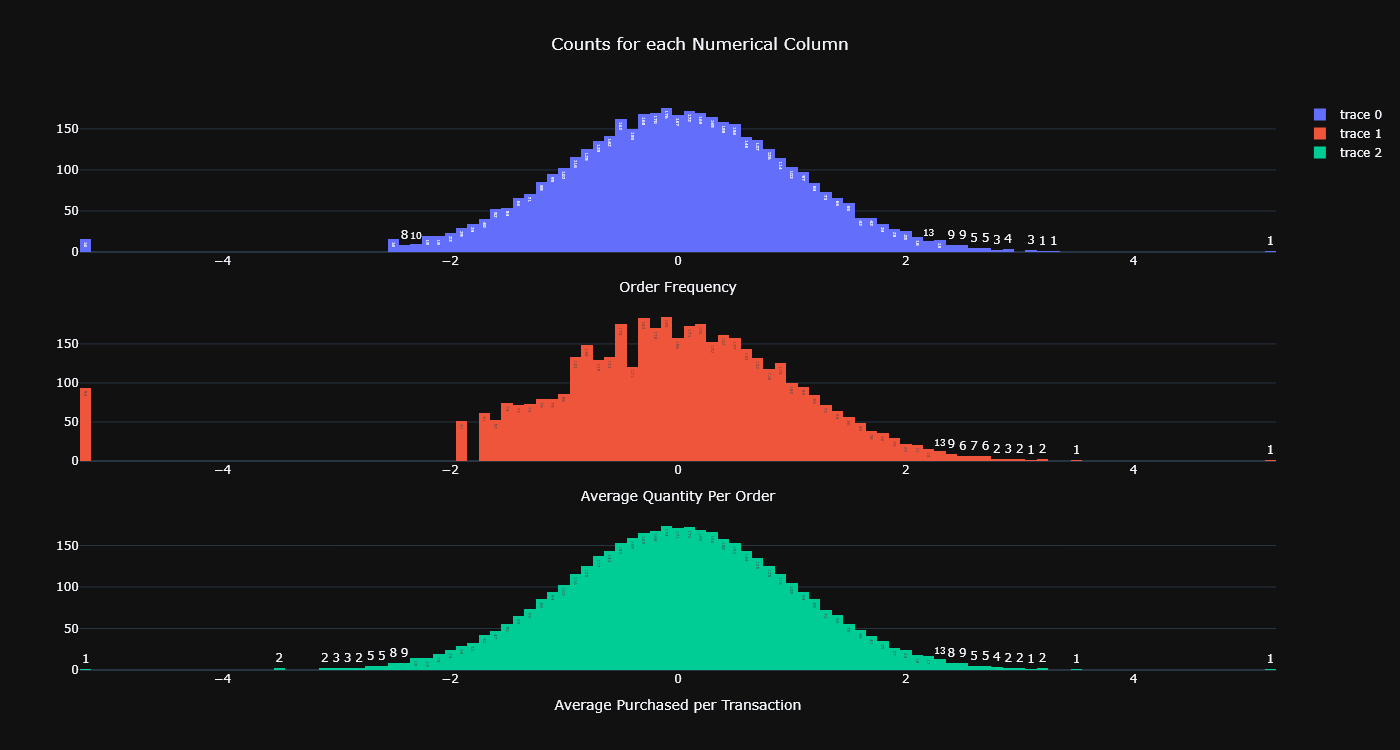

In [ ]:
#Let's see the effects of applying a Quantile Transform on the distribution of our data
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_scaled['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_scaled['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_scaled['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text=  'Order Frequency', row=1, col=1)
fig.update_xaxes(title_text='Average Quantity Per Order', row=2, col=1)
fig.update_xaxes(title_text='Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400, height = 750)
#pio.write_image(fig, 'scaled_hist.png')
Image('scaled_hist.png')

**Figure 3: Feature Distributions After Quantile Transformation**
The histograms clearly show the effect of the transformer. The previously skewed distributions now approximate a standard normal (Gaussian) distribution, making the data ideal for our model.

---
### **5. Justifying Model Complexity with a Likelihood Ratio Test**
Before proceeding with a multi-cluster model, we use a Likelihood Ratio Test to statistically justify the need for more than one component (cluster). We compare the log-likelihood of a single-component GMM against a two-component GMM.

A high LR statistic and a very low p-value will allow us to reject the null hypothesis that a single-component model is sufficient.

In [17]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2

X_check = customer_stats_scaled

# First fit the two different models, and then test the log-likelihood of each
test_model1 = GaussianMixture(n_components=1, random_state=42).fit(X_check)
test_model2 = GaussianMixture(n_components=2, random_state=42).fit(X_check)
log_likelihood1 = test_model1.score(X_check) * X_check.shape[0]
log_likelihood2 = test_model2.score(X_check) * X_check.shape[0]

# Calculate the Likelihood Ratio statistic based on its formula
LR_statistic = -2 * (log_likelihood1 - log_likelihood2)

# Calculate the degrees of freedom and use this value on a chi-squared test
n_features = X_check.shape[1]
n_params1 = 1 * n_features + 1 * (n_features * (n_features + 1) / 2) + (1 - 1)
n_params2 = 2 * n_features + 2 * (n_features * (n_features + 1) / 2) + (2 - 1)
deg_freedom = n_params2 - n_params1
chi_p = chi2.sf(LR_statistic, deg_freedom)

print(f"Likelihood Ratio Statistic: {LR_statistic}")
print(f"p-value: {chi_p:.4f}")

Likelihood Ratio Statistic: 2687.9680554993865
p-value: 0.0000


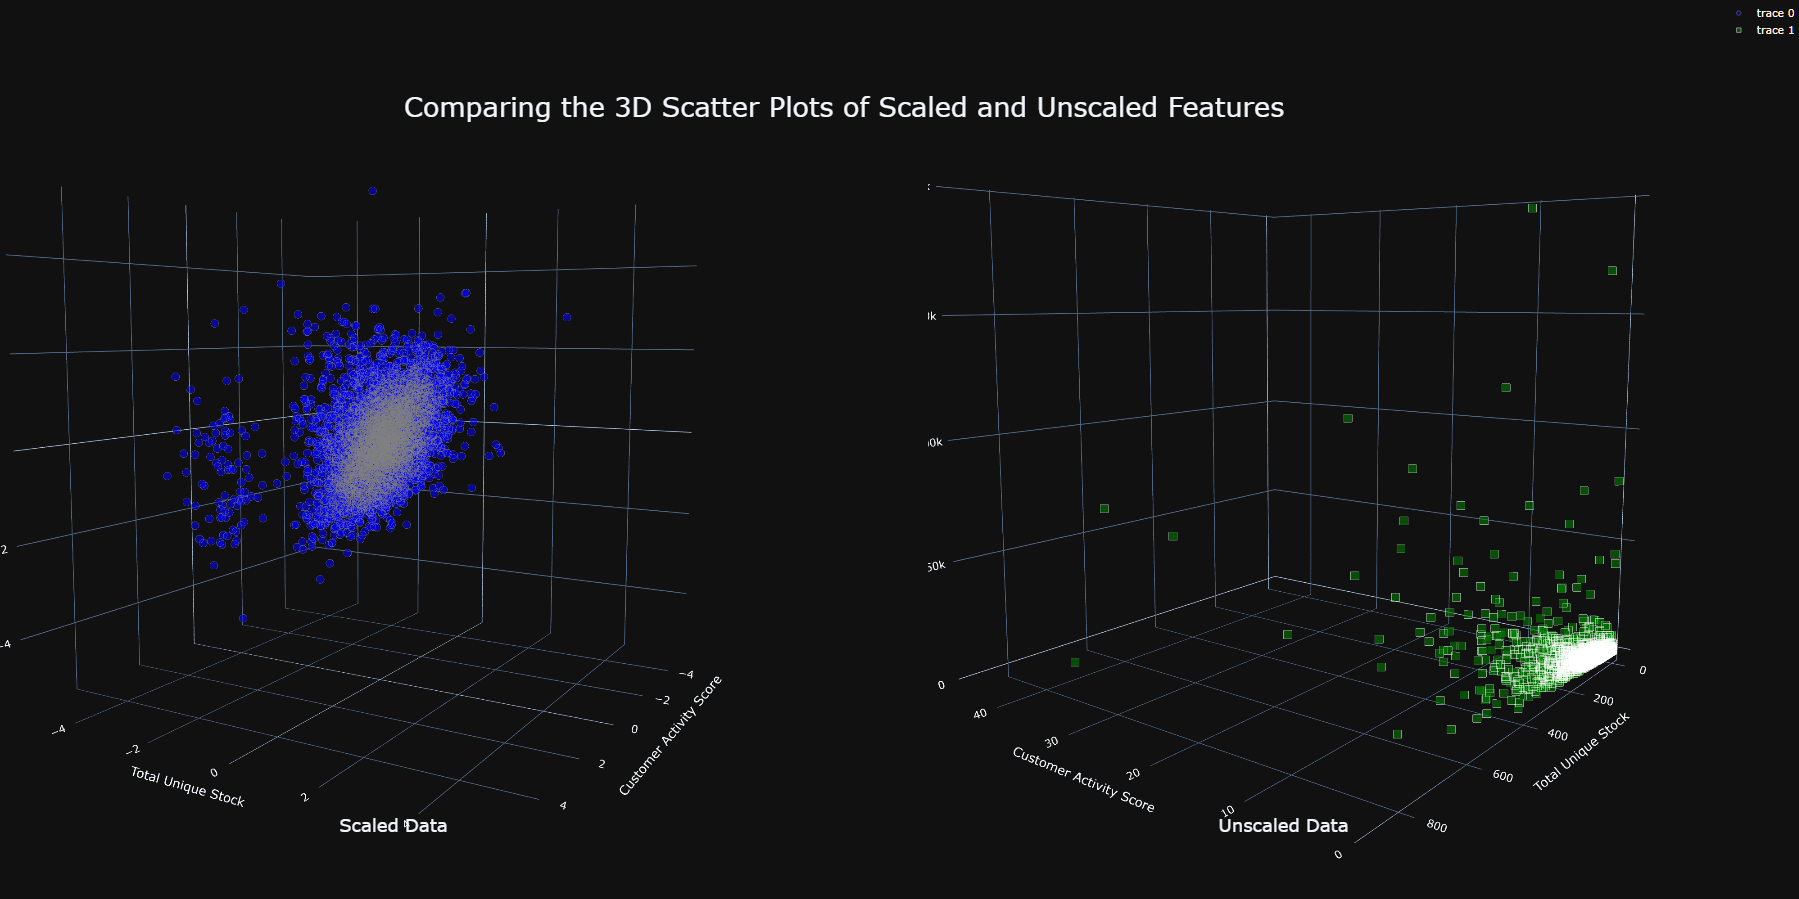

In [ ]:
#Create some 3D scatterplots to visualize how scaling might affect our clustering attempt
fig = subplots.make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_scaled['customer_activity_score']),
        y=np.array(customer_stats_scaled['total_unique_stock']),
        z=np.array(customer_stats_scaled['total_purchases']),
        mode='markers',
        marker=dict(color='blue', symbol='circle', size=5, opacity=0.75,
                    line=dict(color='gray',width=1)),
        line=dict(color='white',width=2)
    ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_no_outliers['customer_activity_score']),
        y=np.array(customer_stats_no_outliers['total_unique_stock']),
        z=np.array(customer_stats_no_outliers['total_purchases']),
        mode='markers',
        marker=dict(color='green', symbol='square', size=5, opacity=0.75,
                    line=dict(color='white',width=1)),
    ),
    row=1, col=2
)

fig.update_layout( width=2000, height=1000, margin=dict(l=0, r=0, b=20, t=0), 
        annotations=[
            dict(text="Scaled Data",  x=0.20, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Unscaled Data",  x=0.8, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Comparing the 3D Scatter Plots of Scaled and Unscaled Features",  x=0.5, y=.9, xref="paper", yref="paper", font=dict(size=30), showarrow=False)],
        scene=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
        scene2=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
    )


#fig.write_html("plot.html")
Image('customer_seg_scaled_unscaled_clusters.png')


**Figure 4: Comparison of Scaled vs. Unscaled Data Distributions**

The difference is clear:
-   **Unscaled Data (Right):** The data is heavily clustered in one corner due to the extreme skew, with outliers creating a sparse, unmanageable distribution.
-   **Scaled Data (Left):** After the quantile transformation, the data is now centered and more uniformly dispersed, forming a Gaussian-like cloud.

This visual evidence confirms that the scaled data provides a much better starting point for a clustering algorithm to identify distinct groups effectively.

---
### **6. Hyperparameter Tuning with Optuna**
We will be using a Gaussian Mixture Model that will incorporate the means produced by separate basic GMM model. This is done to initialize the starting points for our clusters which will enable our main model to converge faster.

To identify the optimal configuration for the Gaussian Mixture Model, the `Optuna` library was used to perform an automated hyperparameter search over 250 trials. The objective was to find the parameters that minimized the **Bayesian Information Criterion (BIC)**, a metric that rewards goodness of fit while penalizing model complexity.

**Search Space:**
-   **`n_components`**:
-   **`covariance_type`**: ['spherical', 'tied', 'diag', 'full']
-   **`init_params`**: ['kmeans', 'random_from_data', 'k-means++', 'random']
-   **`tol`**: [5e-10 to 1e-3]

**Optimal Parameters Found:**
-   **`n_components`**: 6
-   **`covariance_type`**: 'full'
-   **`init_params`**: 'k-means++'
-   **`tol`**: 2.6042e-05

This result provides strong statistical justification for using a **6-component model with a 'full' covariance structure**, indicating that the customer segments have different shapes and orientations.

In [ ]:
import optuna
from optuna.trial import Trial
from sklearn.mixture import GaussianMixture 


#Initialize a seed and X variable
seed = np.random.RandomState(seed=42)
X = customer_stats_scaled[['customer_activity_score', 'total_unique_stock', 'total_purchases']]

def initial_means(n_components, method, seed, tol):
        model = GaussianMixture(
                n_components=n_components, init_params=method, tol=tol, max_iter=0, random_state=seed
            )
        model.fit(X)
        return model.means_

In [ ]:

def objective(trial):
    method = trial.suggest_categorical('method', ["kmeans", "random_from_data", "k-means++", "random"])
    n_components = trial.suggest_int('n_components', 4,6)
    covariance_type = trial.suggest_categorical('covariance_type', ["spherical", "tied", "diag", "full"])
    tol = trial.suggest_float('tol', 5e-10, 1e-3, step=1e-10)
    #print(method, n_components, covariance_type)
    means = initial_means(n_components, method, seed, tol)

    model = GaussianMixture(
            n_components=n_components, means_init=means, covariance_type=covariance_type, tol=tol, max_iter=2000, random_state=seed, verbose=0
        )
    model.fit(X)
    
    score = model.bic(X)
    return score

samplertpe = optuna.samplers.TPESampler( n_startup_trials=10,  n_ei_candidates=15, multivariate=True, group=False)
study = optuna.create_study(directions=['minimize'], sampler=samplertpe)
study.optimize(objective, n_trials=250, n_jobs=1)

### **7. Final Model Implementation**
Using the best hyperparameters from our Optuna study, we train the final Gaussian Mixture Model.

Once trained, we fit the model for a high number of iterations in order to converge to the best BIC score possible.

In [22]:
#Use the parameters determined by our Optuna run to create a GaussianMixture model 
n = 6
c = 'full'
tol = 2.6042e-05


# 2. Define the saved "golden" means from your original run
saved_means = np.array([
    [-0.17910169,  0.21620388, -0.16714437],
    [ 1.02300326,  0.83200627,  1.05748728],
    [-1.1669186 , -5.19933758, -1.12914789],
    [-2.13168157, -0.19825847, -1.10891213],
    [-0.01881964, -1.61133325, -2.09181077],
    [-0.85167519, -0.61654097, -0.25417162]
])

# 3. Initialize the model, feeding it the SAVED means
model = GaussianMixture(
    n_components=n,
    means_init=saved_means,  # <-- This is the critical change
    covariance_type=c,
    tol=tol,
    max_iter=1000,
    random_state=seed,
    verbose=0,
    warm_start=True
)

# 4. Fit the model to your data
model.fit(X)

# 5. Verify the final means
# The output of this should be very close or identical to your 'saved_means'
print("--- Final Cluster Means ---")
print(model.means_)
#Printing the value of the means so that it can be saved to possibly create reproducable clustering attempts

--- Final Cluster Means ---
[[-0.04031506  0.1909102   0.17838766]
 [ 0.24487378  0.24121534  0.23330473]
 [-0.99708005 -5.19933758 -1.23357027]
 [-0.39471044 -0.19825847 -0.27266663]
 [-0.66099486 -0.95530555 -1.07640673]
 [-1.88659091 -0.56172419 -0.67678801]]


In [23]:
#Continue to refit the model for as many iterations needed until no further improvements on BIC occurs
for i in range(0,1000):
    model.fit(X)
        
    score = model.bic(X)
    score
    if i % 100 == 0:
        print(score)

29326.957676366277
29214.693144534926
29214.691034742325
29214.69103362332
29214.691033613177
29214.69103361304
29214.691033613035
29214.69103361303
29214.69103361303
29214.69103361303


 ### **8. Qualitative Analysis: Defining Customer Personas**
With the model trained, we can now predict the cluster label for each customer. To make these labels interpretable, we merge them back to the **unscaled** `customer_stats_no_outliers` dataframe. Analyzing the original, unscaled values is essential for understanding the real-world business meaning of each segment.

In [ ]:
import joblib

# Save the final, fitted model object to a file
#joblib.dump(model, 'final_gmm_model.pkl')
model = joblib.load('final_gmm_model.pkl')
print("\nModel successfully saved to 'final_gmm_model.pkl'")

#Create a copy of our scaled X and add the label outputs generated by our model
X_copy = X.copy()
X_copy['Label'] = model.predict(X)
X_copy['Label'] = X_copy['Label'].astype(str)

label_dict = X_copy['Label'].to_dict()
customer_stats_no_outliers = customer_stats_no_outliers.reset_index()
customer_stats_no_outliers['label'] = customer_stats_no_outliers['index'].map(label_dict)
customer_stats_no_outliers = customer_stats_no_outliers.set_index('index')


#### **8.1. Summary of Customer Personas**
The summary tables reveal six distinct customer personas, which can be grouped into "Core" and "Fringe" segments.

In [77]:
# --- Create a Condensed Summary Table for the CORE CLUSTERS ---

# 1. (This part is from the previous step)
# Generate the describe() outputs and create the initial summary_df
desc_all = X_unscaled.describe()
desc_c0 = X0.describe()
desc_c1 = X1.describe()
desc_c5 = X5.describe()
summary_data_core = {
    'Overall': [desc_all.loc['count', 'num_orders'], desc_all.loc['mean', 'num_orders'], desc_all.loc['mean', 'days_since_last'], desc_all.loc['mean', 'total_unique_stock'], desc_all.loc['mean', 'total_purchases'], desc_all.loc['50%', 'total_purchases']],
    'Cluster 0': [desc_c0.loc['count', 'num_orders'], desc_c0.loc['mean', 'num_orders'], desc_c0.loc['mean', 'days_since_last'], desc_c0.loc['mean', 'total_unique_stock'], desc_c0.loc['mean', 'total_purchases'], desc_c0.loc['50%', 'total_purchases']],
    'Cluster 1': [desc_c1.loc['count', 'num_orders'], desc_c1.loc['mean', 'num_orders'], desc_c1.loc['mean', 'days_since_last'], desc_c1.loc['mean', 'total_unique_stock'], desc_c1.loc['mean', 'total_purchases'], desc_c1.loc['50%', 'total_purchases']],
    'Cluster 5': [desc_c5.loc['count', 'num_orders'], desc_c5.loc['mean', 'num_orders'], desc_c5.loc['mean', 'days_since_last'], desc_c5.loc['mean', 'total_unique_stock'], desc_c5.loc['mean', 'total_purchases'], desc_c5.loc['50%', 'total_purchases']]
}
summary_index = ['Count', 'Mean Orders', 'Mean Days Since Last', 'Mean Unique Stock', 'Mean Total Purchase (£)', 'Median Purchase (£)']
summary_df_core = pd.DataFrame(summary_data_core, index=summary_index)
persona_data_core = {'Overall': '---', 'Cluster 0': '(At-Risk)', 'Cluster 1': '(VIPs)', 'Cluster 5': '(Core Active)'}
persona_row_core = pd.DataFrame(persona_data_core, index=['Persona'])
final_summary_core = pd.concat([persona_row_core, summary_df_core])

# --- START: New code to force string formatting ---

# 2. Create a copy to format for display
formatted_summary_core = final_summary_core.copy()

# 3. Use .applymap() to convert every number to a formatted string
# This will force the viewer to display it correctly.
formatted_summary_core = formatted_summary_core.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

# 4. Display the final, formatted table.
print("--- Summary of Core Customer Segments ---")
display(formatted_summary_core)

--- Summary of Core Customer Segments ---


C:\Users\eckz9\AppData\Local\Temp\ipykernel_5116\3044590063.py:28: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Overall,Cluster 0,Cluster 1,Cluster 5
Persona,---,(At-Risk),(VIPs),(Core Active)
Count,4328.00,1045.00,337.00,2263.00
Mean Orders,4.10,2.70,5.93,5.32
Mean Days Since Last,92.35,101.17,66.18,73.74
Mean Unique Stock,59.93,44.57,14.61,89.17
Mean Total Purchase (£),1839.06,901.45,4937.31,2247.97
Median Purchase (£),665.98,689.57,928.06,1006.98


##### **8.1.1 Core Customer Segments:**
*   **Cluster 5 (Core Active):** The lifeblood of the business. This is the largest segment and scores highly across all metrics: high frequency, high variety, and high monetary value. They are consistent, active buyers.
*   **Cluster 1 (High-Value VIPs):** A smaller but financially critical segment. They have the highest average purchase value by a large margin, often buying high-ticket items. Despite buying a lower variety of products, their monetary contribution is immense.
*   **Cluster 0 (At-Risk):** A large group of customers who are average in value but show signs of lapsing (higher `Mean Days Since Last`). They represent a key opportunity for re-engagement campaigns to prevent churn.


In [29]:

c1_percent = X5["total_purchases"].sum()/X_unscaled["total_purchases"].sum()*100
X5_no_outliers = X5[X5['total_purchases'] < stats_df.loc['99%', 'total_purchases']]
c1_percent2 = X5_no_outliers['total_purchases'].sum()/X_unscaled['total_purchases'].sum()*100
f'Cluster 5 makes up {c1_percent:.2f}% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents {c1_percent2:.2f}% of all sales' 

'Cluster 5 makes up 63.91% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents 52.35% of all sales'

In [78]:
# --- Create a Condensed Summary Table for the FRINGE CLUSTERS ---

# 1. (This part is from the previous step)
# Generate the describe() outputs and create the initial summary_df
desc_c2 = X2.describe()
desc_c3 = X3.describe()
desc_c4 = X4.describe()
summary_data_fringe = {
    'Overall': [desc_all.loc['count', 'num_orders'], desc_all.loc['mean', 'num_orders'], desc_all.loc['mean', 'days_since_last'], desc_all.loc['mean', 'total_unique_stock'], desc_all.loc['mean', 'total_purchases'], desc_all.loc['50%', 'total_purchases']],
    'Cluster 2': [desc_c2.loc['count', 'num_orders'], desc_c2.loc['mean', 'num_orders'], desc_c2.loc['mean', 'days_since_last'], desc_c2.loc['mean', 'total_unique_stock'], desc_c2.loc['mean', 'total_purchases'], desc_c2.loc['50%', 'total_purchases']],
    'Cluster 3': [desc_c3.loc['count', 'num_orders'], desc_c3.loc['mean', 'num_orders'], desc_c3.loc['mean', 'days_since_last'], desc_c3.loc['mean', 'total_unique_stock'], desc_c3.loc['mean', 'total_purchases'], desc_c3.loc['50%', 'total_purchases']],
    'Cluster 4': [desc_c4.loc['count', 'num_orders'], desc_c4.loc['mean', 'num_orders'], desc_c4.loc['mean', 'days_since_last'], desc_c4.loc['mean', 'total_unique_stock'], desc_c4.loc['mean', 'total_purchases'], desc_c4.loc['50%', 'total_purchases']]
}
summary_df_fringe = pd.DataFrame(summary_data_fringe, index=summary_index)
persona_data_fringe = {'Overall': '---', 'Cluster 2': '(Single Product)', 'Cluster 3': '(Churned)', 'Cluster 4': '(Niche)'}
persona_row_fringe = pd.DataFrame(persona_data_fringe, index=['Persona'])
final_summary_fringe = pd.concat([persona_row_fringe, summary_df_fringe])

# --- START: New code to force string formatting ---

# 2. Create a copy to format for display
formatted_summary_fringe = final_summary_fringe.copy()

# 3. Use .applymap() to convert every number to a formatted string
formatted_summary_fringe = formatted_summary_fringe.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

# 4. Display the final, formatted table.
print("\n--- Summary of Fringe Customer Segments ---")
display(formatted_summary_fringe)


--- Summary of Fringe Customer Segments ---


C:\Users\eckz9\AppData\Local\Temp\ipykernel_5116\1916478881.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Overall,Cluster 2,Cluster 3,Cluster 4
Persona,---,(Single Product),(Churned),(Niche)
Count,4328.00,94.00,14.00,575.00
Mean Orders,4.10,1.37,1.00,1.25
Mean Days Since Last,92.35,188.54,373.00,142.36
Mean Unique Stock,59.93,1.00,29.14,9.73
Mean Total Purchase (£),1839.06,1622.74,267.92,191.50
Median Purchase (£),665.98,170.10,260.31,169.55


##### **8.1.2 Fringe Customer Segments:**
*   **Cluster 3 (Churned):** The smallest and most inactive segment. With a `Mean Days Since Last` of 373 days, these are customers who made one purchase and have not returned in over a year.
*   **Cluster 2 (Single Product Wholesalers):** A fascinating niche. These customers have a very low number of unique products but an extremely high mean purchase value, driven by massive bulk orders of a single item (e.g., the £77,000 order).
*   **Cluster 4 (Niche Consumers):** A group of low-frequency, low-value customers who buy a small variety of items. They may be new customers or occasional gift buyers.

- The last 3 clusters are all fringe clusters representing different specific customer segments - with Cluster 2 being the group with the lowest unique stock purchases (actually only a single individual stock), Cluster 3 comprising of single order counts and longest days since last order, while Cluster 4 representing an interesting segment that purchases a specific combination of items in varying degrees of frequency and dollar values. 
- As a whole these clusters constitute a small segment of the business, but some insights might still be gained by identifying what individual or group of items bring certain customers (similar to those in Cluster 4 and 2) to the online storefront, as continuing to provide the same or similar products could help with customer retention.

In [31]:
c234_percent = (X3["total_purchases"].sum()+X2["total_purchases"].sum()+X4["total_purchases"].sum()) /X_unscaled["total_purchases"].sum()*100
c234_percent_order = (X3["num_orders"].sum()+X2["num_orders"].sum()+X4["num_orders"].sum()) /X_unscaled["num_orders"].sum()*100

f'Cluster 2,3 and 4 combined make up {c234_percent:.2f}% of all total sales overall, and {c234_percent_order:.2f}% of all business volume in terms of orders'

'Cluster 2,3 and 4 combined make up 3.35% of all total sales overall, and 4.86% of all business volume in terms of orders'

### **9. Final Model Evaluation: GMM vs. K-Means**
To validate our choice of a Gaussian Mixture Model, we compare it both quantitatively and qualitatively against a baseline K-Means model.

#### **9.1. Quantitative Evaluation & The "Metric Trap"**

As a standard due diligence step, we will quantitatively evaluate the performance of both models using two common clustering metrics: the Silhouette Score and the Davies-Bouldin Score.

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- K-Means Baseline Model ---
# We will use the same number of clusters as the GMM for a direct comparison.
n_clusters_kmeans = 6 

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X)

print("K-Means clustering complete.")

#### **Step 4: Get the Labels from Your GMM (You've already done this)**


# This is from your existing code
gmm_labels = model.predict(X)
print("GMM predictions complete.")
# --- Quantitative Evaluation ---

# 1. Calculate scores for K-Means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(X, kmeans_labels)

# 2. Calculate scores for GMM
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(X, gmm_labels)

# 3. Create a comparison table
results_data = {
    'K-Means': [kmeans_silhouette, kmeans_davies_bouldin],
    'GMM': [gmm_silhouette, gmm_davies_bouldin]
}
results_df = pd.DataFrame(results_data, index=['Silhouette Score (Higher is Better)', 'Davies-Bouldin Score (Lower is Better)'])

print("--- Cluster Evaluation Metrics ---")
display(results_df)

K-Means clustering complete.
GMM predictions complete.
--- Cluster Evaluation Metrics ---


,K-Means,GMM
Silhouette Score (Higher is Better),0.27,0.02
Davies-Bouldin Score (Lower is Better),1.05,1.90


#### **9.2 Metric Interpretation: Why the Numbers Can Be Deceptive**

The results table presents a classic "metric trap." On paper, the K-Means model appears significantly superior: it has a higher Silhouette Score and a lower Davies-Bouldin Score. A naive interpretation would be to select K-Means. However, this conclusion is incorrect because it fails to consider the inherent bias of these metrics.

**The Bias of Centroid-Based Metrics:**

Both the Silhouette Score and the Davies-Bouldin Score are fundamentally **centroid-based, distance metrics**. They assess cluster quality based on two principles:
1.  **Cohesion:** How close are the points within a cluster to each other (or to their cluster's center)?
2.  **Separation:** How far apart are the different clusters from each other?

These metrics work best when clusters are **convex, spherical, and have similar densities.** They reward algorithms that produce tight, ball-shaped groupings.

**Why K-Means Excels at This Specific Test:**

The K-Means algorithm's entire objective function is to minimize the sum of squared distances from each point to its assigned centroid. It is mathematically designed to produce the exact kind of spherical, compact clusters that these metrics are built to reward. In essence, K-Means is acing a test that was written specifically for it.

**Why GMM is Unfairly Penalized:**

Our Gaussian Mixture Model, configured with `covariance_type='full'`, does **not** assume clusters are spherical. Its greatest strength is its flexibility to model clusters as **ellipsoids** of varying sizes, shapes, and orientations. A point can be physically distant from an ellipsoid's center but still have a high probability of belonging to that cluster if it lies along one of its main axes.

The distance-based metrics misinterpret this sophisticated, flexible shape as poor cohesion, unfairly penalizing GMM for the very quality that makes it a better fit for real-world, non-uniform data. This is a textbook example of why a deep understanding of evaluation metrics is crucial. The quantitative scores are mathematically correct but analytically misleading for this problem. A qualitative, visual analysis is therefore essential for proper model selection.

---
#### **9.3 Qualitative Visual Evaluation**

While the quantitative metrics provided a misleading picture, a qualitative analysis of the cluster visualizations provides a definitive answer. The plots below clearly demonstrate why GMM is the superior model for this business problem. To visualize this, we will create 3D scatterplots where the dimensions are the metrics previously chosen. For the GMM clusters, we group fringe and core clusters together. For the KMeans scatterplot, the designation on being a core or fringe cluster does not exist, but we still use the same label groups for a more apt comparison.

In [ ]:
# --- Final GMM Visualization (Scaled Data, Core vs. Fringe) ---

# 1. Prepare the data by splitting into core and fringe groups
X_copy1 = X_copy[X_copy['Label'].isin(['0','1','5'])]
X_copy1['color'] = X_copy1['Label'].astype(int)

X_copy2 = X_copy[X_copy['Label'].isin(['2','3','4'])]
X_copy2['color'] = X_copy2['Label'].astype(int)

# 2. Create the 1x2 subplot figure
# We will use this single figure object for all subsequent steps
fig_gmm_final = subplots.make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('GMM Core Clusters', 'GMM Fringe Clusters')
)

# 3. Define color and symbol maps
color_map = { 0:'#4ad9b4', 1:'#2474b7',  5:'#ef553b', 4:'#00cc96', 2:'#1dd6c9', 3:'#ef553b',} 
symbol_map = {0: 'diamond', 1:'square',  5:'circle',  4: 'circle', 2:'x', 3:'square', } 

# 4. Add the data traces for the CORE plot to fig_gmm_final
for label in set(X_copy1['color']):
    mask = np.array(X_copy1['color']) == label
    fig_gmm_final.add_trace( # <-- Add trace to the correct figure
        go.Scatter3d(
            x=np.array(X_copy1['customer_activity_score'])[mask],
            y=np.array(X_copy1['total_unique_stock'])[mask], 
            z=np.array(X_copy1['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55),
            name=f'GMM Cluster {label}'
        ),
        row=1, col=1
    )

# 5. Add the data traces for the FRINGE plot to fig_gmm_final
for label in set(X_copy2['color']):
    mask = np.array(X_copy2['color']) == label
    fig_gmm_final.add_trace( # <-- Add trace to the correct figure
        go.Scatter3d(
            x=np.array(X_copy2['customer_activity_score'])[mask],
            y=np.array(X_copy2['total_unique_stock'])[mask],
            z=np.array(X_copy2['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55),
            name=f'GMM Cluster {label}'
        ),
        row=1, col=2
    )

# 6. Update the layout of fig_gmm_final with all formatting
fig_gmm_final.update_layout(
    title_text="Customer Segmentation Comparison: GMM Results (on Scaled Data)",
    width=1700, height=900,
    margin=dict(l=0, r=0, b=20, t=80),
    title_font_size=30,
    font=dict(size=14),
    scene=dict(
        domain=dict(x=[0, 0.5], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    scene2=dict(
        domain=dict(x=[0.51, 1.0], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    legend=dict(
        font_size=16
    )
)

for anno in fig_gmm_final.layout.annotations:
    anno.y = 0.90  # The default is ~0.98. Lower this value to move the titles down.
    anno.yanchor = 'bottom' # Anchors the bottom of the text to the y-coordinate
# --- END: New code ---




# 7. Show the final, complete figure
#pio.write_image(fig_gmm_final, r'notebook referenced files/gmm1.png')


In [ ]:

# --- Final K-Means Visualization (Scaled Data, Core vs. Fringe) ---

# 1. Create a copy of the scaled data and add the K-Means labels
X_kmeans_copy = X.copy()
X_kmeans_copy['KMeans_Label'] = kmeans_labels
X_kmeans_copy['KMeans_Label'] = X_kmeans_copy['KMeans_Label'].astype(str)

# 2. IMPORTANT: Analyze the .describe() output for each K-Means cluster
# and update the lists below with the correct labels for YOUR results.
kmeans_core_labels = ['0', '1', '5']  # <-- CONFIRM THIS based on your analysis
kmeans_fringe_labels = ['2', '3', '4'] # <-- CONFIRM THIS based on your analysis

# 3. Split the scaled data into core and fringe groups
kmeans_core_df = X_kmeans_copy[X_kmeans_copy['KMeans_Label'].isin(kmeans_core_labels)]
kmeans_fringe_df = X_kmeans_copy[X_kmeans_copy['KMeans_Label'].isin(kmeans_fringe_labels)]

# 4. Create the 1x2 subplot figure
fig_kmeans_final = subplots.make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('K-Means Core Clusters', 'K-Means Fringe Clusters')
)

# 5. Define color and symbol maps
color_map = { 0:'#4ad9b4', 1:'#ef553b', 2:'#ab63fa', 3:'#00cc96', 4:'#ef553b', 5:'#ab63fa'} 
symbol_map = {0: 'circle', 1:'circle', 2:'circle', 3: 'circle', 4:'circle', 5:'circle' }

# 6. Add the data traces for the CORE plot
for label_str in kmeans_core_labels:
    label_int = int(label_str)
    mask = kmeans_core_df['KMeans_Label'] == label_str
    fig_kmeans_final.add_trace(
        go.Scatter3d(
            x=kmeans_core_df[mask]['customer_activity_score'],
            y=kmeans_core_df[mask]['total_unique_stock'], 
            z=kmeans_core_df[mask]['total_purchases'],
            mode='markers',
            marker=dict(color=color_map[label_int], symbol=symbol_map[label_int], size=5, opacity=0.7),
            name=f'K-Means Cluster {label_str}'
        ),
        row=1, col=1
    )

# 7. Add the data traces for the FRINGE plot
for label_str in kmeans_fringe_labels:
    label_int = int(label_str)
    mask = kmeans_fringe_df['KMeans_Label'] == label_str
    fig_kmeans_final.add_trace(
        go.Scatter3d(
            x=kmeans_fringe_df[mask]['customer_activity_score'],
            y=kmeans_fringe_df[mask]['total_unique_stock'],
            z=kmeans_fringe_df[mask]['total_purchases'],
            mode='markers',
            marker=dict(color=color_map[label_int], symbol=symbol_map[label_int], size=5, opacity=0.7),
            name=f'K-Means Cluster {label_str}'
        ),
        row=1, col=2
    )

# 8. --- Final Layout Update for K-Means Plot ---
# This block is identical to the GMM layout for perfect uniformity.
fig_kmeans_final.update_layout(
    title_text="Customer Segmentation Comparison: K-Means Results (on Scaled Data)", # <-- Title changed
    width=2000, height=900,
    margin=dict(l=0, r=0, b=20, t=80),
    title_font_size=30,
    font=dict(size=14),
    scene=dict(
        domain=dict(x=[0, 0.5], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    scene2=dict(
        domain=dict(x=[0.51, 1.0], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    legend=dict(
        font_size=16
    )
)

# 9. Adjust subplot title positions to match the GMM plot
for anno in fig_kmeans_final.layout.annotations:
    anno.y = 0.90
    anno.yanchor = 'bottom'

# 10. Show the final, complete figure
#pio.write_image(fig_kmeans_final, r'notebook referenced files/km1.png')



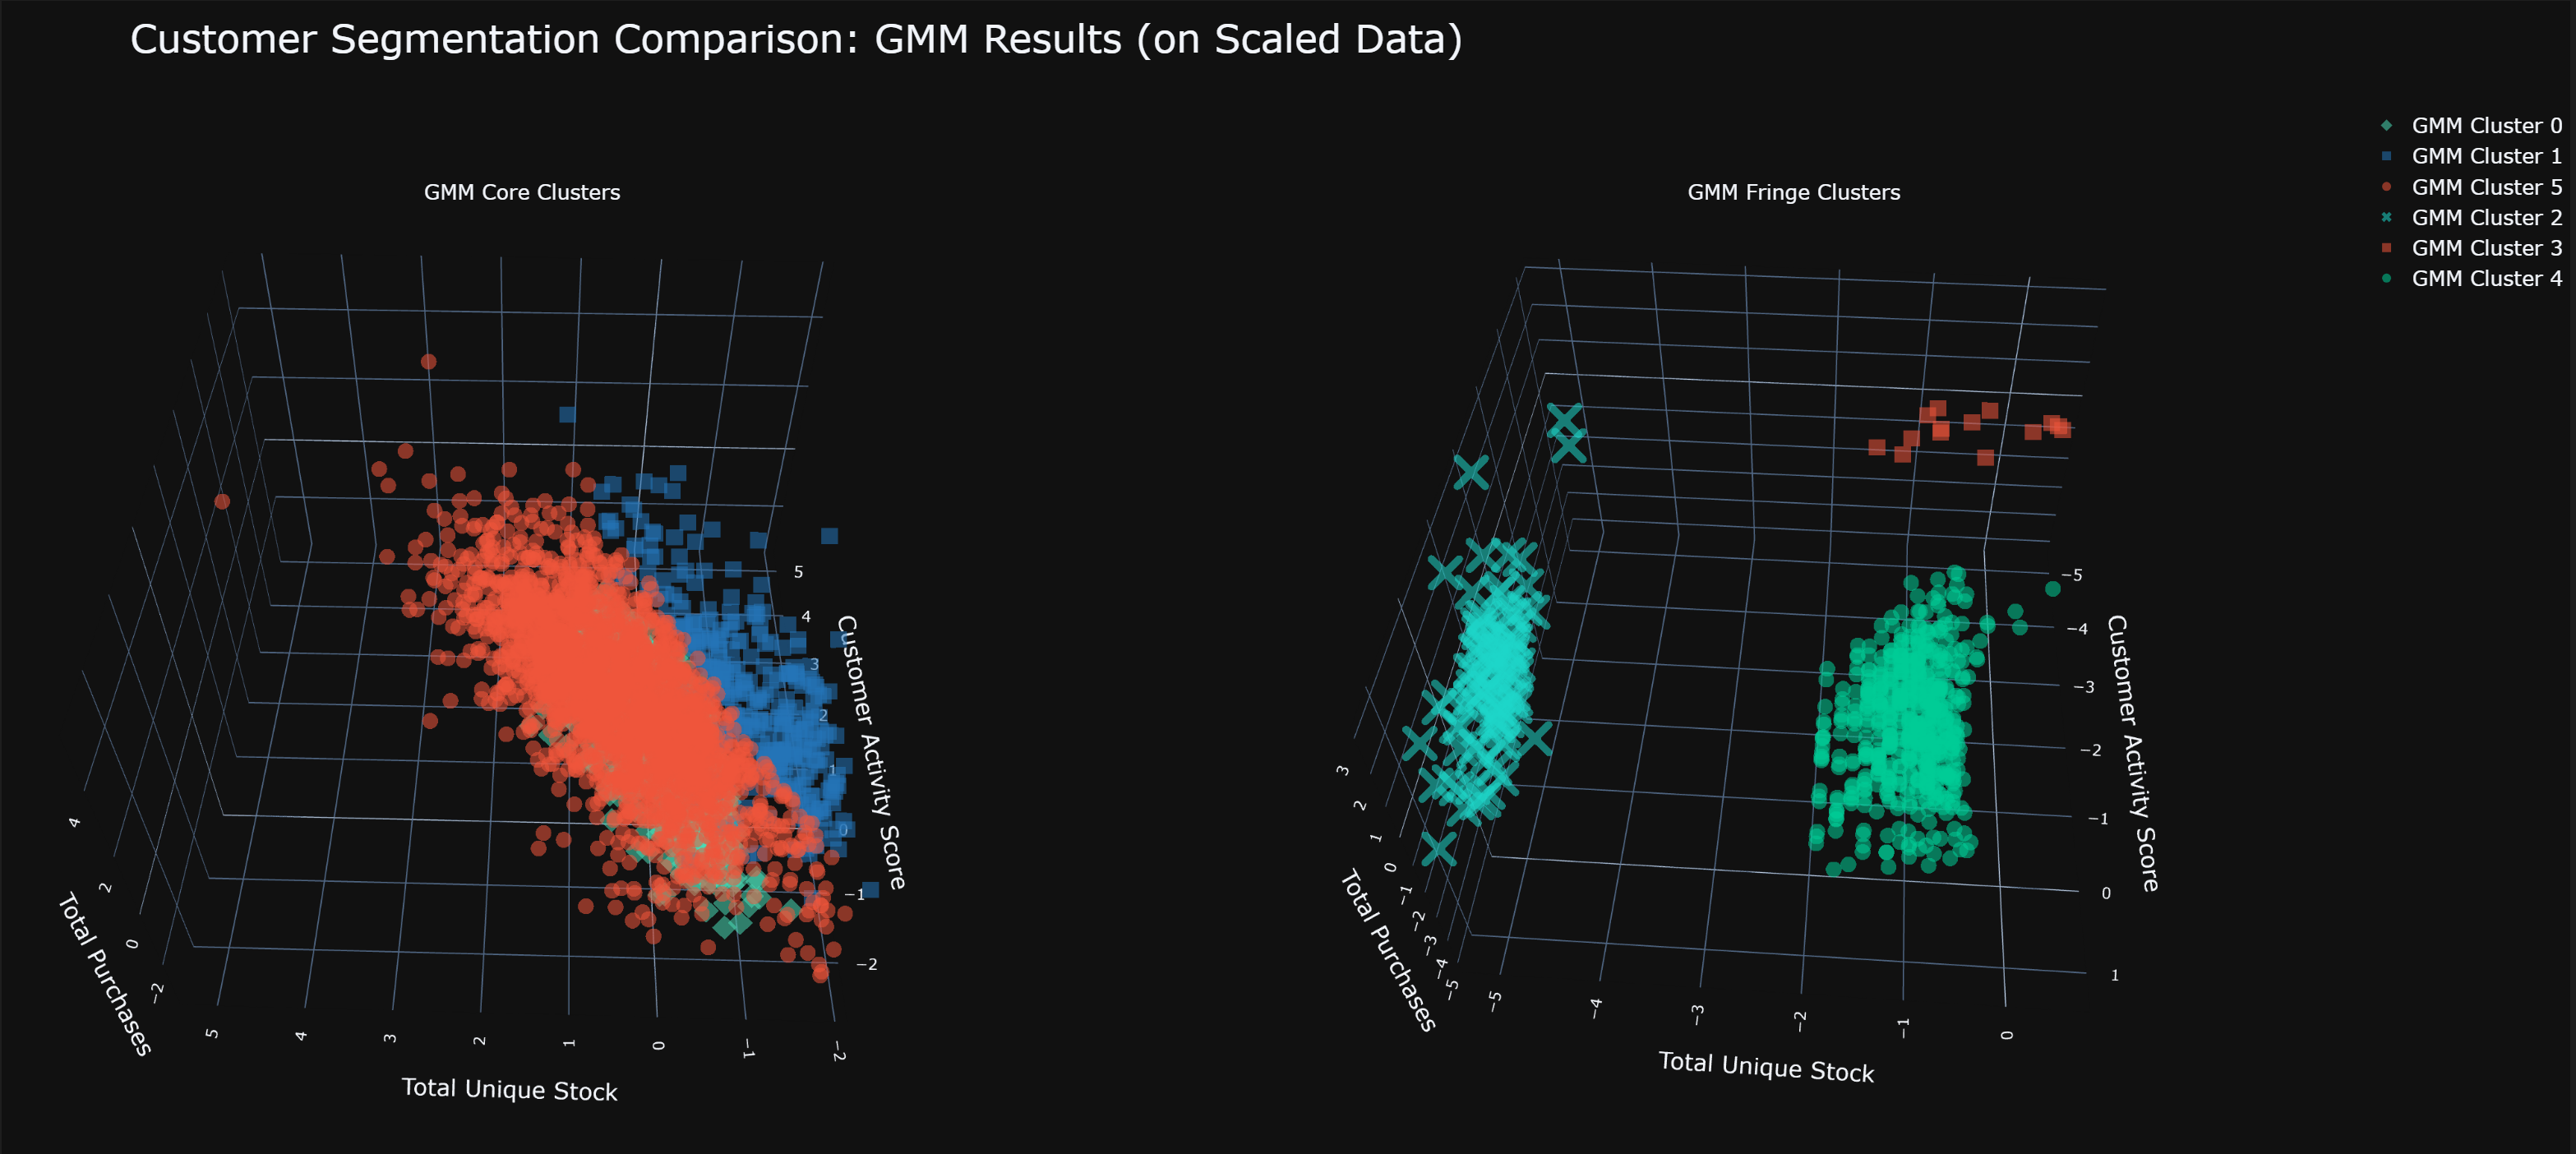

In [ ]:
Image(r'notebook referenced files/gmm1.png')

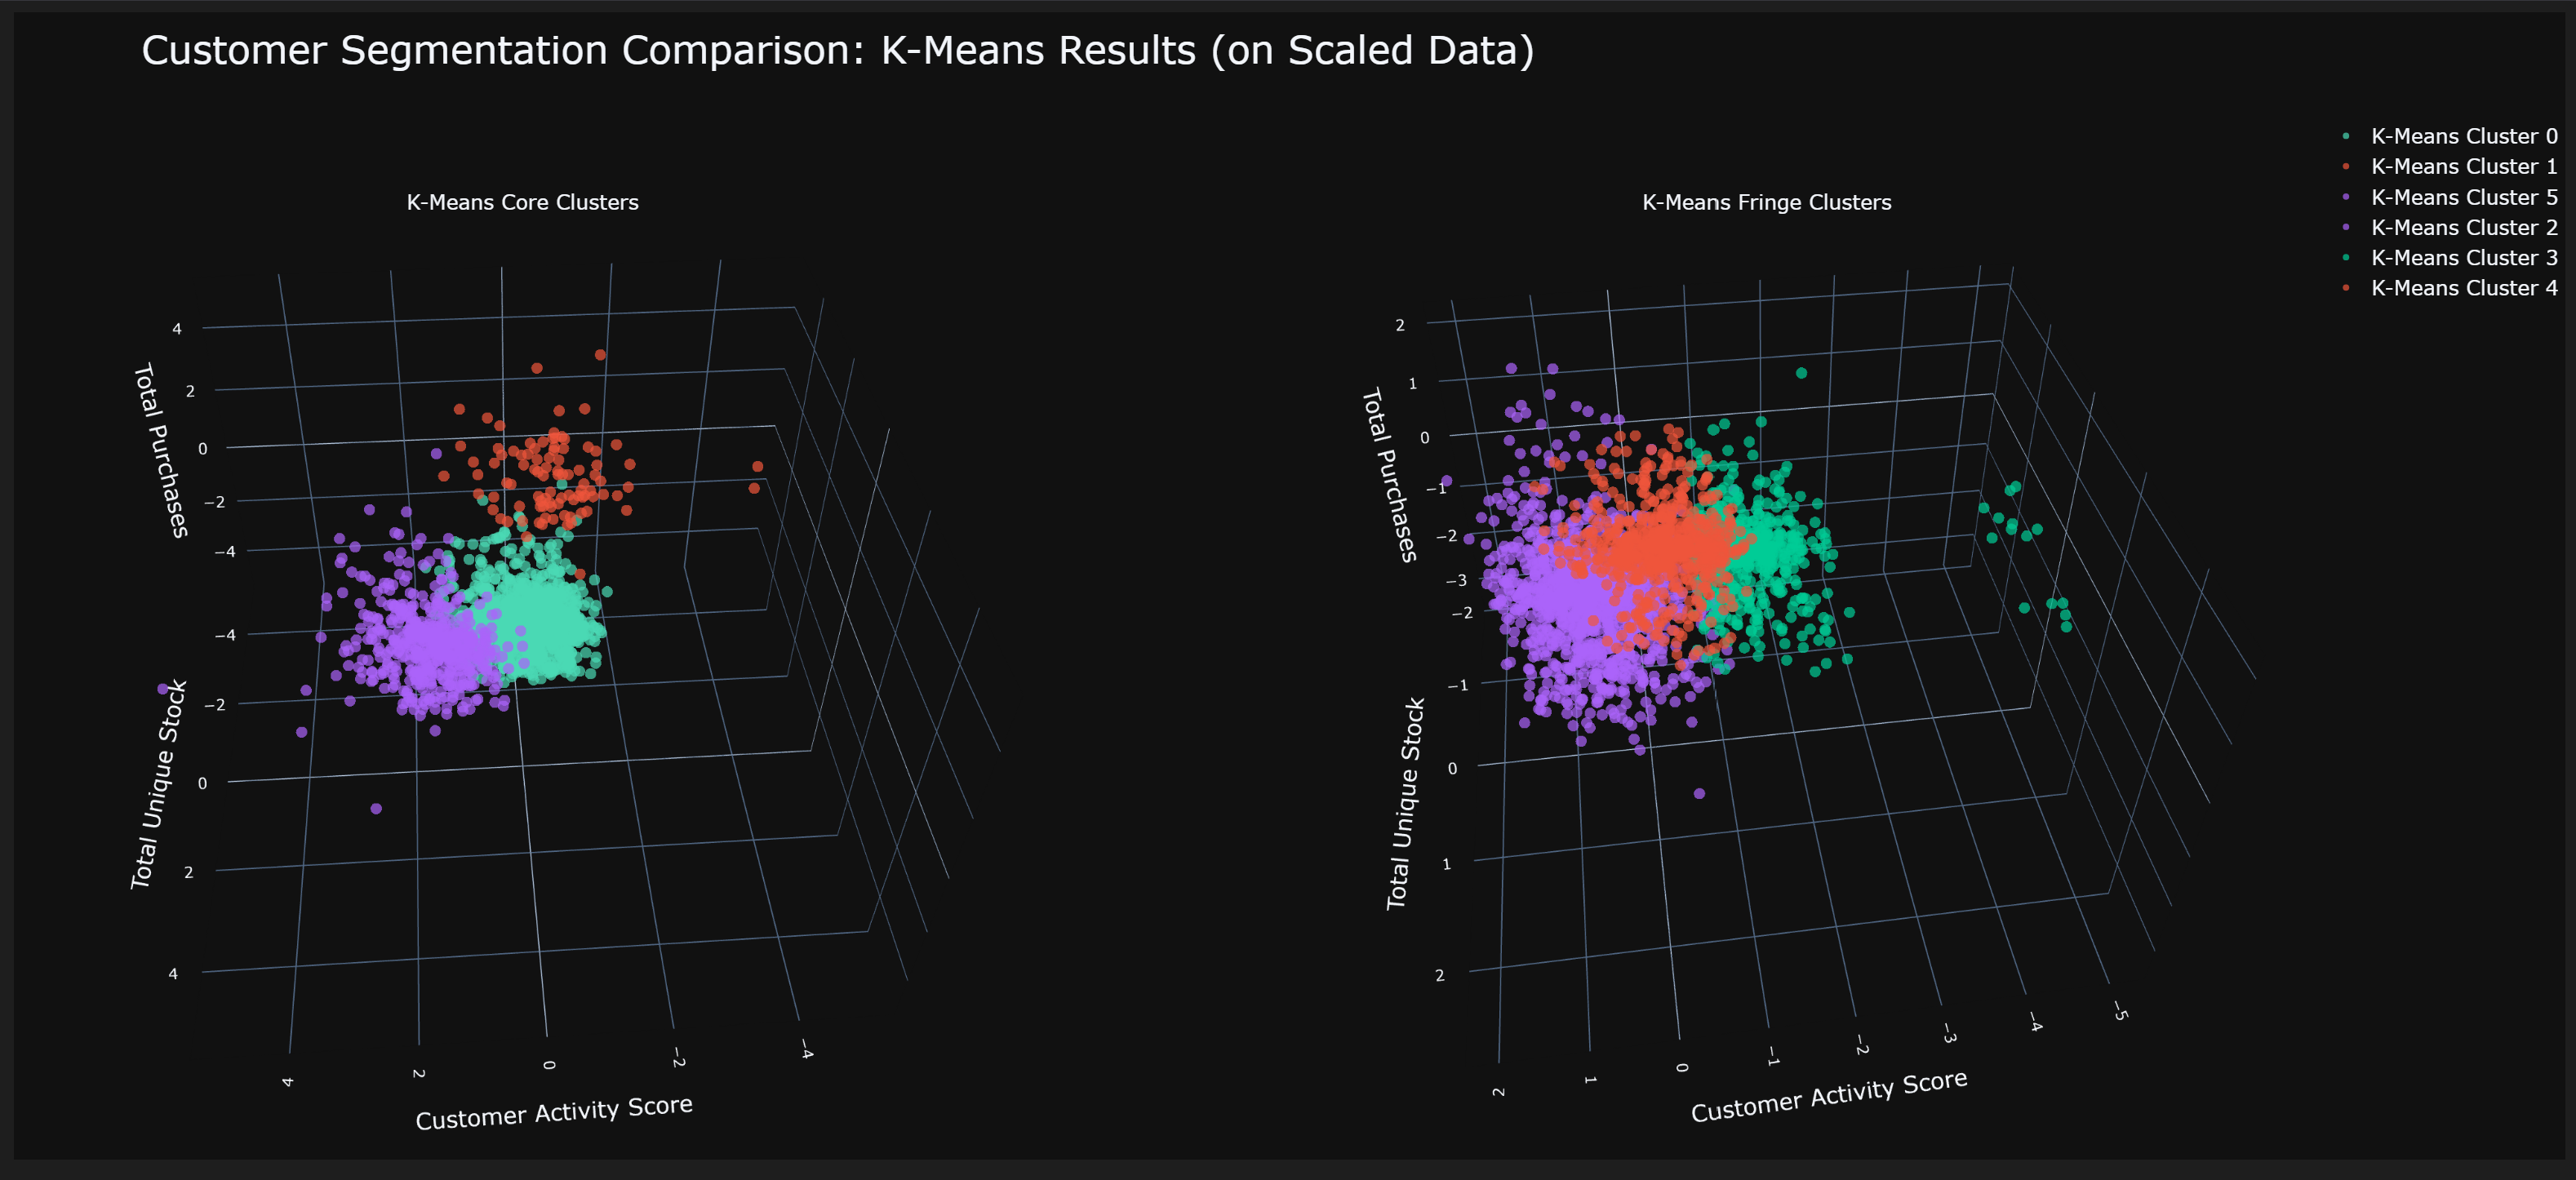

In [ ]:
Image(r'notebook referenced files/km1.png')

### **9.4 Visual Analysis: Why GMM Succeeds Where K-Means Fails**

**The K-Means Model: A Failure of Uniformity**

The K-Means visualization (bottom plot) reveals a high degree of uniformity among its clusters. The segments are roughly equal in size, spherical, and evenly spaced. This homogeneity is the exact opposite of what is needed for effective customer segmentation. The goal is to find what makes groups *different*, but K-Means has forced the population into artificially similar boxes. If all customer segments appear indistinguishable, it's impossible to identify the unique purchasing habits that define them, making it useless for deriving targeted business strategies.

**The GMM Model: Capturing Real-World Variety**

In stark contrast, the GMM visualization (top plot) successfully models the inherent variety within the customer base, producing clusters of varying sizes, shapes, densities, and orientations. This flexibility allows the model to uncover meaningful, actionable business patterns that K-Means completely missed:

*   **A Clear Positive Trend in Core Customers:** In the "Core Clusters" plot (top left), we can see a clear positive linear trend. This indicates that the most valuable customer segments are those who score well across multiple metrics simultaneously (high activity, high purchase variety, and high monetary value).
*   **Isolation of Meaningful Fringe Segments:** In the "Fringe Clusters" plot (top right), the GMM successfully isolates smaller, distinct groups. The placement of these clusters in the feature space directly corresponds to their business meaning—for example, the "Churned" customers are correctly placed in a region of low activity and high recency.

**Conclusion**

Ultimately, the GMM's ability to model the complex, non-spherical geometry of the data is what makes it the superior choice. It doesn't force customers into arbitrary shapes; it **reveals the segments as they truly exist in the data.** This provides a foundation for genuinely actionable business insights, something the K-Means model, despite its better quantitative scores, completely failed to do.